# **Recognize Places from Images**

We aim to learn a model that recognizes places or objects seen before. For example, given images of a place, can the robot recognize the same place from a different viewpoint?

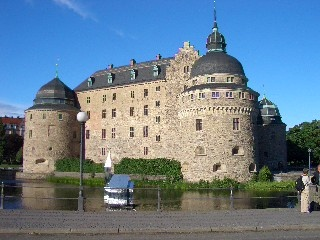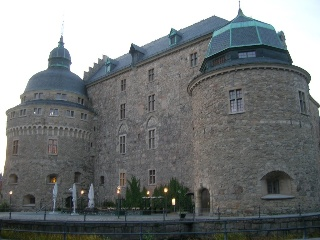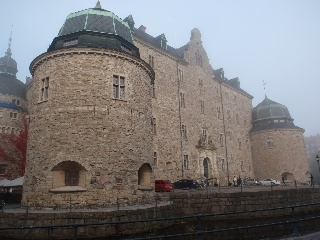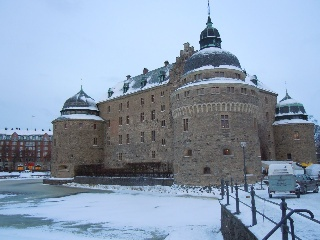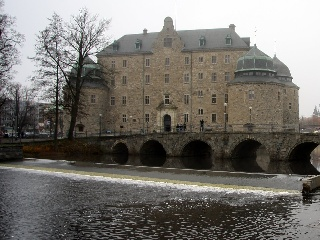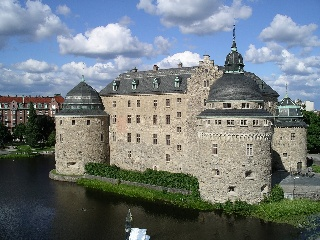

### **1. Preparation**



**Check Python version.**

In [ ]:
!python -V

**Check Cuda version.**

In [ ]:
!nvcc -V

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
pip install torch torchvision

In [ ]:
pip install opencv-python

In [ ]:
# Check if runtime uses GPU
import torch

gpu_name = torch.cuda.get_device_name(0)
print("Using GPU", gpu_name)

In [ ]:
from os import path, chdir, getcwd, mkdir
projectDirectory = "/content/drive/My Drive/SceneRecognition"
chdir(projectDirectory)

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1cEwFq4reck3Fu8eAOX2_cFVyDednFui1' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1cEwFq4reck3Fu8eAOX2_cFVyDednFui1" -O data.zip 

In [ ]:
!unzip data.zip


In [ ]:
projectDirectory = "/content/drive/My Drive/SceneRecognition"
chdir(projectDirectory)
!rm data.zip # to save spacee NVIDIA® Tesla® K80 Accelerator dramatically lowers data center costs by delivering exceptional performance with fewer, more powerful servers. It's engineered to boost throughput in real-world applications by 5-10x, while also saving customers up to 50% for an accelerated data center compared to a CPU-only 

### **ResNet50 Transfer Learning Model**

In [ ]:
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F


class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)


class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # self.cnn = nn.Sequential(
        #     nn.Conv2d(3, 32, 3, stride=2), nn.ReLU(),
        #     nn.Conv2d(32, 32, 3, stride=2), nn.ReLU(),
        #     nn.Conv2d(32, 32, 3, stride=2), nn.ReLU(),
        #     nn.Conv2d(32, 64, 3, stride=2), nn.ReLU(),
        #     nn.Conv2d(64, 64, 3, stride=2), nn.ReLU(),
        #     nn.Conv2d(64, 64, 3, stride=1), nn.ReLU(),
        #     Flatten())
        self.cnn = models.resnet50(pretrained = True)
        for name, param in self.cnn.named_parameters():
          if("bn" not in name):
            param.requires_grad = False

        unfreeze_layers = [self.cnn.layer3, self.cnn.layer4]
        for layer in unfreeze_layers:
          for param in layer.parameters():
            param.requires_grad = True
        # for param in self.cnn.parameters():
        #     param.requires_grad = False

        nLinearFeatures = self.cnn.fc.in_features

        self.cnn.fc = nn.Sequential(
            nn.Linear(nLinearFeatures, 1024), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(1024, 512), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(512, 25))

        # self.fc = nn.Sequential(
        #     nn.Linear(1792, 1024), nn.ReLU(),
        #     nn.Linear(1024, 512), nn.ReLU(),
        #     nn.Linear(512, 25))

    def forward(self, inputs):
        inputs = F.interpolate(inputs, 224)
        output = self.cnn(inputs)
        # output = self.fc(output)
        scores = F.log_softmax(output, dim=-1)

        return scores


### **Data Loading**

In [ ]:
import os
import cv2
from PIL import Image
import PIL
from torch.utils.data import Dataset
from torchvision import transforms


class MyDataset(Dataset):

    def __init__(self, is_train=True, num_cat=200):
        self.num_cat = num_cat
        self.is_train = is_train
        self.data_path = "train"
        self._load_file_list()

    def __len__(self):
        return len(self.labels)

    def _load_file_list(self):
        image_files = []
        labels = []

        work_folders = [int(f) for f in os.listdir(self.data_path) if os.path.isdir(os.path.join(self.data_path, f))]
        work_folders.sort()
        work_folders = work_folders[:self.num_cat]
        for cat in work_folders:
            cat = str(cat)
            cat_folder = os.path.join(self.data_path, cat)
            images = [f for f in os.listdir(cat_folder) if os.path.isfile(os.path.join(cat_folder, f))]
            images = images[:-50] if self.is_train else images[-50:]

            for img in images:
                img_file = os.path.join(cat_folder, img)
                image_files.append(img_file)
                labels.append(cat)

        self.image_files = image_files
        self.labels = labels

    def __getitem__(self, idx):
        img = cv2.imread(self.image_files[idx])
        if img is None:
            return self.__getitem__((idx + 1) % self.__len__())

        img = Image.open(self.image_files[idx])
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
        if self.is_train == True:
          img_transforms = transforms.Compose([
              # # transforms.Resize((224,224)),
              transforms.ColorJitter(hue=.05, saturation=.05),
              transforms.RandomHorizontalFlip(),
              transforms.RandomAffine(degrees=40, scale=(.9, 1.1), shear=0),
              transforms.GaussianBlur(11, sigma=(0.1, 2.0)),
              transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
              transforms.ToTensor(),
              normalize,
          ])
        else:
          img_transforms = transforms.Compose([
              transforms.ToTensor(),
              normalize,
          ])
        img = img_transforms(img)
        label = int(self.labels[idx])

        sample = {
            'img': img,
            'label': label
        }

        return sample


### **Model Training**



In [ ]:
from os import path, chdir, getcwd, mkdir
projectDirectory = "/content/drive/My Drive/SceneRecognition"
chdir(projectDirectory)

In [ ]:
import torch
import multiprocessing as mp
from torch.optim.lr_scheduler import ReduceLROnPlateau


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def train():
    my_model = MyModel()
    my_model = my_model.cuda().float()
    batch_size = 32
    num_epoch = 10
    num_classes = 25

    train_set = MyDataset(is_train=True, num_cat=num_classes)
    validation_set = MyDataset(is_train=False, num_cat=num_classes)


    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
    validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=True, pin_memory=True)
    
    optimizer = torch.optim.Adam([
                  { 'params': my_model.cnn.layer4.parameters(), 'lr': 1e-3 /3},
                  { 'params': my_model.cnn.layer3.parameters(), 'lr': 1e-3 /9},
                  ], lr=1e-3)
    loss_func = torch.nn.NLLLoss()
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=500,
                                  threshold=2e-1, verbose=True, min_lr=1e-5)

    print("start training")
    for epoch in range(num_epoch):
        total = 0
        correct = 0
        my_model.train()
        for i, data in enumerate(train_loader, 0):
            optimizer.zero_grad()
            labels = data['label'].cuda()
            img = data['img'].cuda().float()
            prediction = my_model(img)

            loss = loss_func(prediction, labels)
            loss.backward()
            optimizer.step()
            scheduler.step(loss)

            _, predicted = torch.max(prediction, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            print('[epoch: %5d/%5d, batch: %5d] loss: %.3f, lr: %.10f, acc %d %%'
                  % (epoch, num_epoch, i, loss.clone().item(), get_lr(optimizer), (100 * correct / total)))

        # validation accuracy
        total = 0
        correct = 0
        my_model.eval()
        for i, data in enumerate(validation_loader, 0):
            labels = data['label'].cuda()
            img = data['img'].cuda().float()
            prediction = my_model(img)

            _, predicted = torch.max(prediction, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('[epoch: %5d/%5d] validation acc %d %%'
              % (epoch, num_epoch, (100 * correct / total)))

        torch.save(my_model.state_dict(), "my_model_bn_ia_bs_tr_final.pt")


if __name__ == "__main__":
    train()


start training


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1201: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


[epoch:     0/   10, batch:     0] loss: 3.218, lr: 0.0003333333, acc 3 %
[epoch:     0/   10, batch:     1] loss: 3.213, lr: 0.0003333333, acc 1 %
[epoch:     0/   10, batch:     2] loss: 3.182, lr: 0.0003333333, acc 3 %
[epoch:     0/   10, batch:     3] loss: 3.186, lr: 0.0003333333, acc 3 %
[epoch:     0/   10, batch:     4] loss: 3.225, lr: 0.0003333333, acc 3 %
[epoch:     0/   10, batch:     5] loss: 3.177, lr: 0.0003333333, acc 6 %
[epoch:     0/   10, batch:     6] loss: 3.173, lr: 0.0003333333, acc 7 %
[epoch:     0/   10, batch:     7] loss: 3.164, lr: 0.0003333333, acc 7 %
[epoch:     0/   10, batch:     8] loss: 3.139, lr: 0.0003333333, acc 9 %
[epoch:     0/   10, batch:     9] loss: 3.116, lr: 0.0003333333, acc 10 %
[epoch:     0/   10, batch:    10] loss: 3.081, lr: 0.0003333333, acc 12 %
[epoch:     0/   10, batch:    11] loss: 3.083, lr: 0.0003333333, acc 12 %
[epoch:     0/   10, batch:    12] loss: 3.094, lr: 0.0003333333, acc 13 %
[epoch:     0/   10, batch:    13]

### **Model Testing**


In [ ]:
projectDirectory = "/content/drive/My Drive/SceneRecognition"
chdir(projectDirectory)

In [ ]:
# import torch

def test():
    my_model = MyModel()
    my_model = my_model.cuda().float()
    batch_size = 32

    my_model.load_state_dict(torch.load('my_model_bn_ia_bs_tr_final.pt'))
    validation_set = MyDataset(is_train=False, num_cat=25)

    # mp.set_start_method('spawn', force=True)
    validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=True)

    # validation accuracy
    total = 0
    correct = 0
    for i, data in enumerate(validation_loader, 0):
        labels = data['label'].cuda()
        img = data['img'].cuda().float()
        prediction = my_model(img)

        _, predicted = torch.max(prediction, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print('[batch: %5d], acc %d %%'
              % ( i, (100 * correct / total)))

    print('validation acc %d %%' % (100 * correct / total))


if __name__ == "__main__":
    test()


[batch:     0], acc 100 %
[batch:     1], acc 98 %
[batch:     2], acc 98 %
[batch:     3], acc 99 %
[batch:     4], acc 98 %
[batch:     5], acc 98 %
[batch:     6], acc 98 %
[batch:     7], acc 98 %
[batch:     8], acc 98 %
[batch:     9], acc 97 %
[batch:    10], acc 97 %
[batch:    11], acc 97 %
[batch:    12], acc 97 %
[batch:    13], acc 97 %
[batch:    14], acc 97 %
[batch:    15], acc 97 %
[batch:    16], acc 97 %
[batch:    17], acc 97 %
[batch:    18], acc 97 %
[batch:    19], acc 97 %
[batch:    20], acc 97 %
[batch:    21], acc 97 %
[batch:    22], acc 97 %
[batch:    23], acc 97 %
[batch:    24], acc 97 %
[batch:    25], acc 97 %
[batch:    26], acc 97 %
[batch:    27], acc 97 %
[batch:    28], acc 97 %
[batch:    29], acc 98 %
[batch:    30], acc 98 %
[batch:    31], acc 98 %
[batch:    32], acc 98 %
[batch:    33], acc 98 %
[batch:    34], acc 97 %
[batch:    35], acc 97 %
[batch:    36], acc 97 %
[batch:    37], acc 97 %
[batch:    38], acc 97 %
[batch:    39], acc 97 %